In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

%matplotlib inline

In [0]:
def build_train_and_test_set(path_train,path_test,path_rul,window_h,window_w,seed,t_v_split):
  
  #CREACION DE FEATURES MAPS Y RULS PARA ENTRENAMIENTO (Y VALIDACION) 

  df = pd.read_csv(path_train, sep = ' ', header = None)
  df = df.drop(columns=[26, 27])
  df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)
  
  RUL_temp=np.zeros(0)
  for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
  df['RUL'] = RUL_temp
  df['RUL'] = df['RUL'].astype(int)
  scaler = MinMaxScaler(feature_range=(-1,1))
  df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

  # Creación de features maps
  features_maps=np.empty((window_h,window_w,1))
  df_ys = np.zeros((1,1))
  
  #se obtienen los dataset de engines independientes en df_temp
  for i in range(1,df['n_engine'].max()+1):
    df_temp1 = df[df['n_engine'] == i]
    df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_features = df_temp2.drop(['RUL'],axis = 1)
    df_y = df_temp2['RUL'].to_numpy()
    df_ys = np.append(df_ys,df_y[(window_h - 1):])
    for j in range(len(df_y)-(window_h - 1)):
      feature_map = df_features[j:j+(window_h)][:]
      features_maps = np.dstack((features_maps, feature_map))
  features_maps=np.delete(features_maps, 0, 2)
  df_ys = np.delete(df_ys, 0, 0)
  
  # cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps = np.moveaxis(features_maps, 2, 0)

  # Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
  df_ys = np.expand_dims(df_ys,axis=1)
  features_maps= np.expand_dims(features_maps,3)

  #random para pares (X,Y) del conjunto de entrenamiento
  features_maps, df_ys = shuffle(features_maps, df_ys, random_state=seed)

  #valores de RUL mayores a 125 se seteean en 125
  for i in range(len(df_ys)):
    if df_ys[i] >= 125:
      df_ys[i] = 125

  ys_train = df_ys[:int(len(df_ys)*(t_v_split))]
  ys_valid = df_ys[int(len(df_ys)*(t_v_split)):]

  features_maps_train = features_maps[:int(len(df_ys)*(t_v_split))]
  features_maps_valid = features_maps[int(len(df_ys)*(t_v_split)):]

  #CREACION DE FEATURES MAPS Y RULS PARA TESTEO

  df_t = pd.read_csv(path_test, sep = ' ', header = None)
  df_t = df_t.drop(columns=[26, 27])
  df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

  #se obtienen los dataset de engines independientes en df_temp
  features_maps_test=np.empty((window_h,window_w,1))
  for i in range(1,df_t['n_engine'].max()+1):
    df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_large = df_temp['sens_8'].count()
    feature_map = df_temp[df_large-(window_h):][:]
    features_maps_test = np.dstack((features_maps_test, feature_map))
  features_maps_test=np.delete(features_maps_test, 0, 2)
  
  # cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps_test = np.moveaxis(features_maps_test, 2, 0)
  features_maps_test = np.expand_dims(features_maps_test,3)

  ruls_test= []
  rul_file = open(path_rul, "r")
  for rul_line in rul_file:
    ruls_test.append(int(rul_line.rstrip(' \n')))

  ruls_test_final = np.array(ruls_test)
  features_maps_test_final = np.array(features_maps_test)
  idx   = np.argsort(ruls_test_final)

  ruls_test_final = np.array(ruls_test_final)[idx]
  features_maps_test_final = np.array(features_maps_test_final)[idx]

  for i in range(len(ruls_test_final)):
    if ruls_test_final[i] >= 125:
      ruls_test_final[i] = 125

  return ys_train, ys_valid, features_maps_train, features_maps_valid, ruls_test_final, features_maps_test_final


In [0]:
y_train1, y_valid1, f_maps_train1, f_maps_valid1, r_test_f1, f_maps_test_f1 = (build_train_and_test_set('train_FD001.txt','test_FD001.txt','RUL_FD001.txt',30,14,5,0.9)) 

In [0]:
y_train2, y_valid2, f_maps_train2, f_maps_valid2, r_test_f2, f_maps_test_f2 = (build_train_and_test_set('train_FD002.txt','test_FD002.txt','RUL_FD002.txt',20,14,5,0.9)) 

# CNN 

Propuesta de Li, Ding, Sun

![Imagen](https://github.com/farayal/memoria_turbofan/blob/master/cnn_regression.png?raw=true)

In [6]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [8]:
cnnturbofan = cnnturbofan(((f_maps_train1.shape[1]),(f_maps_train1.shape[2]),(f_maps_train1.shape[3])))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [10]:
history = cnnturbofan.fit(x = f_maps_train1, y = y_train1 ,batch_size=1024, epochs = 250 ,validation_data=(f_maps_valid1,y_valid1))




Train on 15957 samples, validate on 1774 samples
Epoch 1/250





15957/15957 [==============================] - 9s 552us/step - loss: 7286.6638 - root_mean_squared_error: 85.2651 - val_loss: 6307.4822 - val_root_mean_squared_error: 79.4141
Epoch 2/250
15957/15957 [==============================] - 1s 49us/step - loss: 6147.0876 - root_mean_squared_error: 78.3952 - val_loss: 5958.3768 - val_root_mean_squared_error: 77.1845
Epoch 3/250
15957/15957 [==============================] - 1s 50us/step - loss: 5820.8259 - root_mean_squared_error: 76.2827 - val_loss: 5695.4613 - val_root_mean_squared_error: 75.4622
Epoch 4/250
15957/15957 [==============================] - 1s 50us/step - loss: 5584.9309 - root_mean_squared_error: 74.7222 - val_loss: 5480.2164 - val_root_mean_squared_error: 74.0226
Epoch 5/250
15957/15957 [==============================] - 1s 49us/step - loss: 5372.7626 - root_mean_squared_error: 73.2943 - val_loss: 5274.0191 - val_root_mean_squared_error: 72.6167
Epoch 6/250


In [11]:
cnnturbofan.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 14, 10)        110       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 14, 10)        

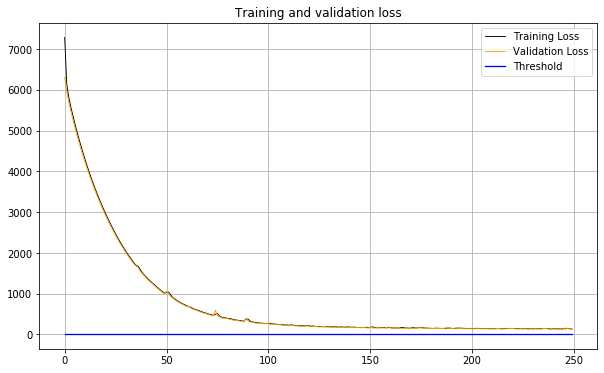

In [12]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

In [0]:
holi = cnnturbofan.predict(f_maps_test_f1)

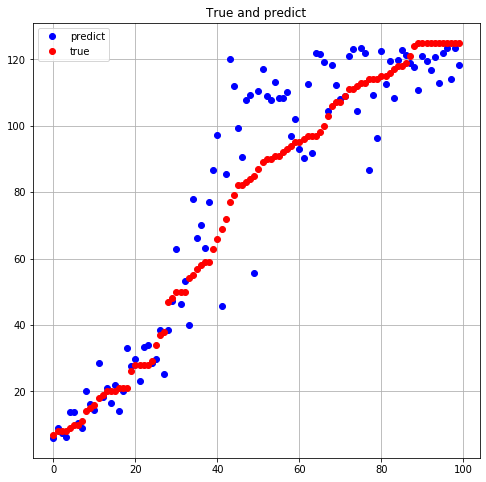

In [14]:
leng = range(100)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(8,8))
plt.grid(True) 
plt.plot(leng, holi, 'bo',lw=0.9, label='predict')
plt.plot(leng, r_test_f1, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(holi, r_test_f1))
print(rmse)

13.358786728586013


### FD002

In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [0]:
cnnturbofan2 = cnnturbofan(((f_maps_train2.shape[1]),(f_maps_train2.shape[2]),(f_maps_train2.shape[3])))

In [0]:
cnnturbofan2.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [19]:
history2 = cnnturbofan2.fit(x = f_maps_train2, y = y_train2 ,batch_size=1024, epochs = 250 ,validation_data=(f_maps_valid2,y_valid2))

Train on 43937 samples, validate on 4882 samples
Epoch 1/250
43937/43937 [==============================] - 2s 56us/step - loss: 6937.5528 - root_mean_squared_error: 83.1594 - val_loss: 6098.6508 - val_root_mean_squared_error: 78.0814
Epoch 2/250
43937/43937 [==============================] - 2s 36us/step - loss: 5808.3695 - root_mean_squared_error: 76.1987 - val_loss: 5500.1041 - val_root_mean_squared_error: 74.1505
Epoch 3/250
43937/43937 [==============================] - 2s 36us/step - loss: 5251.6939 - root_mean_squared_error: 72.4614 - val_loss: 4990.2036 - val_root_mean_squared_error: 70.6296
Epoch 4/250
43937/43937 [==============================] - 2s 36us/step - loss: 4770.7219 - root_mean_squared_error: 69.0594 - val_loss: 4543.1600 - val_root_mean_squared_error: 67.3916
Epoch 5/250
43937/43937 [==============================] - 2s 36us/step - loss: 4347.5752 - root_mean_squared_error: 65.9277 - val_loss: 4149.3535 - val_root_mean_squared_error: 64.4047
Epoch 6/250
43937/439

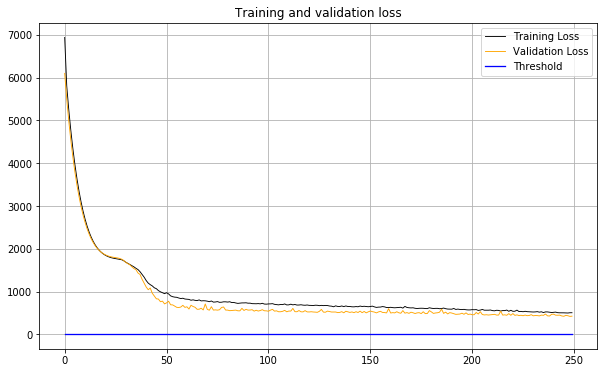

In [20]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

In [0]:
holi2 = cnnturbofan2.predict(f_maps_test_f2)

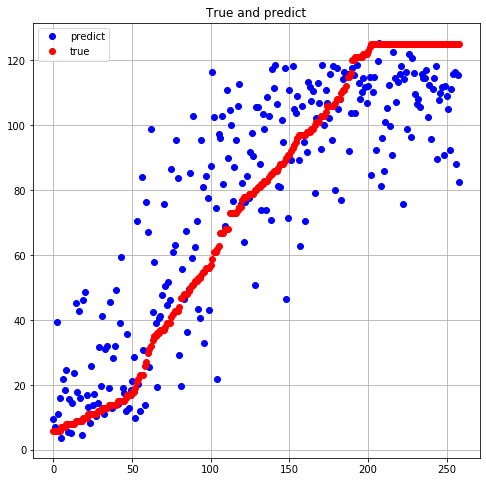

In [22]:
leng = range(259)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(8,8))
plt.grid(True) 
plt.plot(leng, holi2, 'bo',lw=0.9, label='predict')
plt.plot(leng, r_test_f2, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [24]:
rmse = sqrt(mean_squared_error(holi2, r_test_f2))
print(rmse)

21.381686275712514
